In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('transfusion.csv')

In [15]:
df.head()

Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  \
0                 2                 50                  12500             98   
1                 0                 13                   3250             28   
2                 1                 16                   4000             35   
3                 2                 20                   5000             45   
4                 1                 24                   6000             77   

   whether he/she donated blood in March 2007  
0                                           1  
1                                           1  
2                                           1  
3                                           1  
4                                           0

In [16]:
df.rename(
    columns={'whether he/she donated blood in March 2007': 'Target'},
    inplace=True
)

In [18]:
df.describe()

Recency (months)  Frequency (times)  Monetary (c.c. blood)  \
count        748.000000         748.000000             748.000000   
mean           9.506684           5.514706            1378.676471   
std            8.095396           5.839307            1459.826781   
min            0.000000           1.000000             250.000000   
25%            2.750000           2.000000             500.000000   
50%            7.000000           4.000000            1000.000000   
75%           14.000000           7.000000            1750.000000   
max           74.000000          50.000000           12500.000000   

       Time (months)      Target  
count     748.000000  748.000000  
mean       34.282086    0.237968  
std        24.376714    0.426124  
min         2.000000    0.000000  
25%        16.000000    0.000000  
50%        28.000000    0.000000  
75%        50.000000    0.000000  
max        98.000000    1.000000

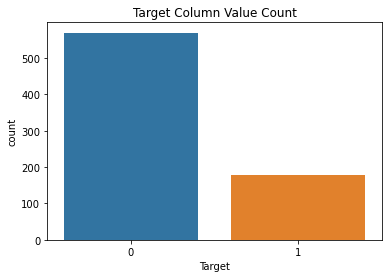

In [17]:
plt.title('Target Column Value Count')
sns.countplot(x="Target", data=df);

In [21]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y

X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=42, stratify=y)                

print(X_train.head())
print(y_train[:5])

     Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)
529                 2                  6                   1500             22
271                16                  7                   1750             28
455                21                  1                    250             21
175                11                 10                   2500             35
309                16                  3                    750             19
[1 0 0 0 0]


In [22]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

tpot_clf = TPOTClassifier(
    generations=5,
    population_size=100,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot_clf.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.7457909192970235
Generation 2 - Current best internal CV score: 0.7480116103643626
Generation 3 - Current best internal CV score: 0.7480116103643626
Generation 4 - Current best internal CV score: 0.7547899225426534
Generation 5 - Current best internal CV score: 0.7547899225426534
Best pipeline: LogisticRegression(ZeroCount(MinMaxScaler(input_matrix)), C=20.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=5,
               log_file=<ipykernel.iostream.OutStream object at 0x00000245EDED00D0>,
               random_state=42, scoring='roc_auc', verbosity=2)

In [23]:
tpot_auc_score = roc_auc_score(y_test, tpot_clf.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot_clf.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


AUC score: 0.7795

Best pipeline steps:
1. MinMaxScaler()
2. ZeroCount()
3. LogisticRegression(C=20.0, random_state=42)


In [25]:
from sklearn.preprocessing import MinMaxScaler

X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

transformer = MinMaxScaler().fit_transform(X_train_scaled)
transformer = MinMaxScaler().fit_transform(X_test_scaled)

In [29]:
from sklearn import linear_model

model = linear_model.LogisticRegression(
    C=20.0,
    random_state=42
)
model.fit(X_train_scaled, y_train)
model_auc_score = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
model_auc_score

0.7880116959064327

In [31]:
import pickle
filename='model.pkl'
pickle.dump(model, open(filename, 'wb'))